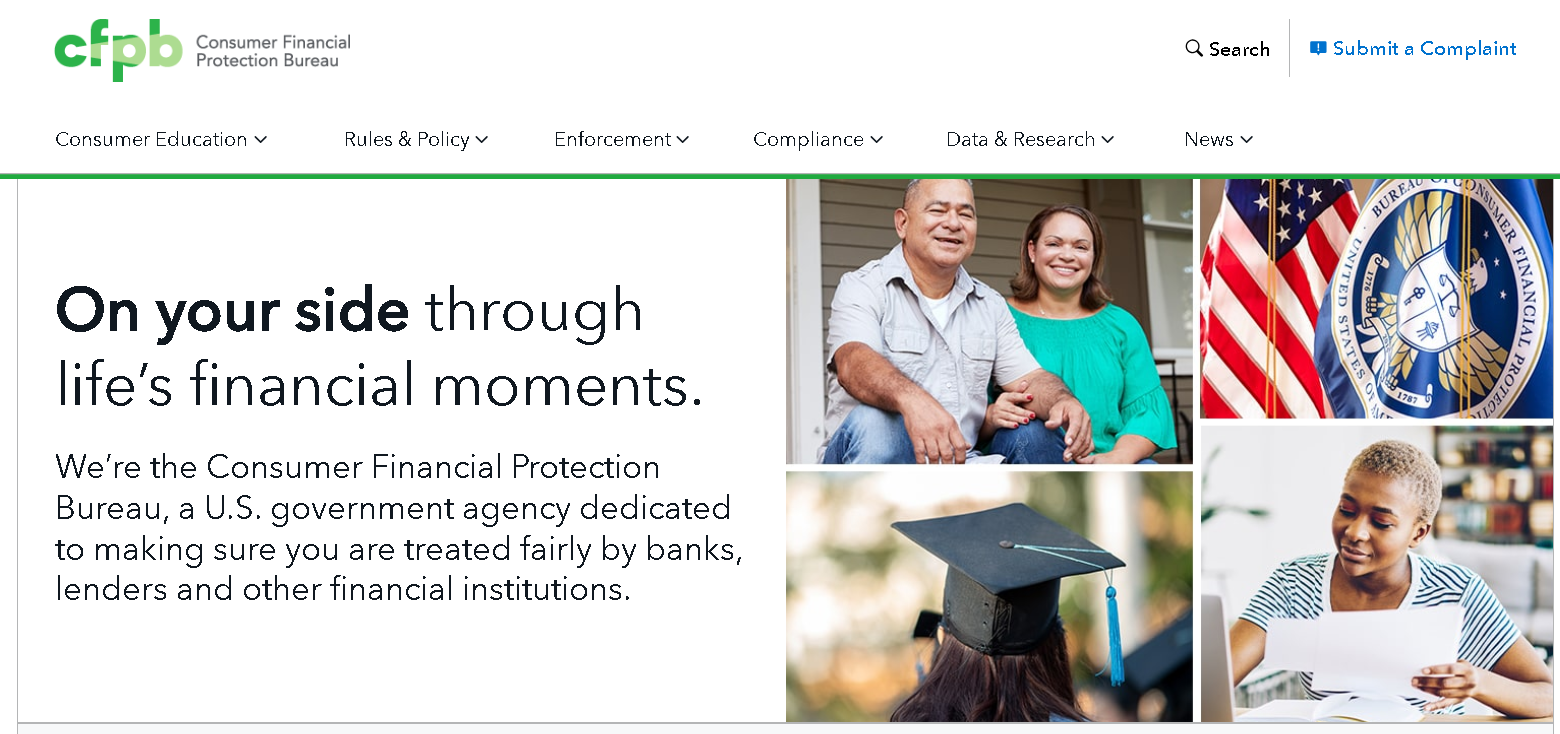

**Collaborators: Shoval Benjer 319037404,Alon Berkovic 208432625 Adir Amar 209017755**


תרשים זרימה פשוט של Kafka + Spark
```
     +-----------------+         (1) כתיבת נתונים
     |  Data Producer  |       למערכות קצה/שירותים
     +--------+--------+
              |
              v  (הודעות נכנסות)      
     +------------------------+
     |        Kafka          |  <-- מנוהל כ-Cluster
     |   (Topic Raw Data)    |  <-- אחסון הודעות מתמיד
     +------------+----------+
                  |
          (2) Spark Structured Streaming
                  |
                  v (מושך נתונים בקצב רציף)
     +------------------------+
     |  Spark (Consumer)     |  <-- עושה Preprocessing, EDA, ML
     |  ML Pipeline/EDA etc. |
     +------------+----------+
                  |
     (3) כתיבת התוצאות
     -> בחזרה ל-Kafka (Topic אחר)  או ל-DB / קבצים

```


פירוט השלבים בתרשים:


Data Producer (יישום חיצוני / מערכת אחרת) שולח את הנתונים ל-TOPIC ספציפי ב-Kafka.
Spark Structured Streaming מוגדר כ-Consumer שמנוי לטופיק. הוא קורא את ההודעות, ממיר אותן ל-DataFrame, ומריץ עליהן עיבוד/ניתוח.
לאחר העיבוד, Spark יכול לכתוב את הפלט לטופיק חדש ב-Kafka (כדי שיתקבל ע"י צרכנים אחרים), או לשמור ל-DB/Data Lake.
4. יתרונות עיקריים בגישה זו
אסינכרוניות וסקיילביליות

Kafka מאפשר לטפל בכמויות גדולות של הודעות בו-זמנית, בעוד Spark יכול להתרחב (Scale out) על אשכול (Cluster) כדי לעבד את המידע במקביל.
עמידות לתקלות (Fault-tolerance)

גם אם Spark נופל לכמה זמן, Kafka שומרת את ההודעות (log) עד ש-Spark יעלה שוב וימשיך מהמקום שהפסיק.
הפרדה בין שלבי המערכת

יצרן (Producer) לא צריך לדעת על העיבוד, ו-Spark (Consumer) לא צריך לדעת על המקור המדויק של הנתונים.
אם רוצים להחליף את Spark בכלי אחר לעיבוד, ניתן לעשות זאת ללא שינוי בצד של ה-Producer.


In this notebook, we have:
1. **Loaded** `filtered_DATASET.csv` into Spark.
2. Performed **basic EDA**:
   - Distribution of text length (histogram).
   - Box plot of numeric columns (like text_length).
   - Top unigrams and bigrams (via `CountVectorizer`).
3. **Built a Spark ML pipeline** to cluster:
   - **Tokenization** + **Stopword removal** → tokens.
   - **TF-IDF** vectorization → numeric features.
   - **KMeans** clustering.
4. **Found** an optimal `k` (2 to 5 range) with the **Silhouette** score.
5. **Analyzed** cluster assignments for the final best model.

This end-to-end example demonstrates how to do
**text-based clustering** using Spark for big data scenarios,
alongside essential EDA visuals via Pandas/Seaborn/Matplotlib.

#**Setup**

**System Requirements:**

    Operating System: Linux-based environment (recommended for compatibility) or Windows with WSL2.

Software:
    Python 3.8+, Java 8 (OpenJDK 8), and Apache Spark.

Libraries:

    pyspark, kafka-python, threading, and json.

Environment Setup:

**Google Colab is Recommended for running the notebook.**

Local System: Ensure you have Apache Spark and Kafka installed with appropriate environment variables configured.


Description for Each Step:

      Install Java:
      This command installs the OpenJDK 8 runtime environment, a necessary dependency for running Apache Spark and Kafka. The -qq flag minimizes output during the installation process.

      Download Apache Spark:
      Downloads Apache Spark version 3.5.0 with Hadoop 3 compatibility from the official Apache archives. Spark is a distributed computing framework essential for big data processing tasks.

      Verify the Spark Download:
      Lists the downloaded Spark tarball to confirm that the file has been successfully downloaded.

      Extract the Spark Archive:
      Unpacks the Spark tarball to make the Spark distribution files accessible for configuration and usage.

      Move Spark to the Local Directory:
      Moves the extracted Spark directory to /usr/local/spark, setting a standard location for Spark installation, simplifying environment variable configuration.

      Download Apache Kafka:
      Downloads Apache Kafka version 3.5.1 (Scala version 2.13), a distributed event-streaming platform commonly used for real-time data pipelines and streaming applications.

      Verify the Kafka Download:
      Lists the downloaded Kafka tarball to ensure successful file retrieval.

      Extract the Kafka Archive:
      Unpacks the Kafka tarball to access its binaries and configuration files.

      Move Kafka to the Local Directory:
      Moves the extracted Kafka directory to /usr/local/kafka for organized setup and easier configuration.

      Set Environment Variables:
      Configures environment variables for Java, Spark, and Kafka to ensure their executables can be accessed system-wide. This includes updating the PATH variable for seamless command-line operations.

      Install Python Libraries:
      Installs pyspark for interacting with Spark using Python and kafka-python for Kafka integration within Python applications.

      Start Zookeeper:
      Launches Zookeeper, a centralized service used by Kafka for managing distributed systems. It provides configuration synchronization and group services for Kafka brokers.

      Start Kafka Broker:
      Starts the Kafka broker service, which handles message queuing, storage, and distribution to clients in a publish-subscribe model.

# Step 1: Imports and Setup

We start by importing PySpark, Python data libraries (like pandas, matplotlib, seaborn),
and then initializing our Spark session.

In [ ]:
"""
Imports and Spark session initialization.
Make sure you have PySpark, Pandas, Seaborn, and Matplotlib installed in your environment.
"""
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, length, regexp_replace, split, explode, count, desc,
    lower, udf, monotonically_increasing_id
)
from pyspark.sql.types import StringType, IntegerType, DoubleType

from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, CountVectorizer, VectorAssembler,
    StandardScaler, IDF, HashingTF
)
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
spark = SparkSession.builder \
    .appName("ConsumerComplaintsClustering") \
    .getOrCreate()

# Step 2: Load filtered_DATASET.csv and do a quick preview

Our dataset presumably has columns like:
- "Consumer complaint narrative"
- Possibly more columns like "Date received", "State", etc.

We show a few rows to verify the structure.


In [ ]:
def load_data(file_path: str) -> DataFrame:
    """
    Loads CSV data into a Spark DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file (e.g., 'filtered_DATASET.csv').

    Returns:
    - DataFrame: Spark DataFrame with inferred schema.
    """
    df = spark.read \
        .option("header", True) \
        .option("inferSchema", True) \
        .csv(file_path)
    return df

file_path = "filtered_DATASET.csv"
df = load_data(file_path)

print("Schema of the loaded DataFrame:")
df.printSchema()

print("Preview first 5 rows:")
df.show(5, truncate=80)

# Step 3: Basic Exploratory Data Analysis (EDA)

We'll do some EDA on:
1. Text length distribution
2. Simple boxplot for numeric columns if any
3. Word frequency (top unigrams) and bigrams


In [ ]:
def explore_text_length(df: DataFrame, text_col: str = "Consumer complaint narrative"):
    """
    Adds a 'text_length' column to measure the number of characters in each complaint.
    Then collects a sample to local pandas for plotting a histogram.

    Parameters:
    - df (DataFrame): Source DataFrame with a text column.
    - text_col (str): The column that contains the complaint text.
    """
    df_len = df.withColumn("text_length", length(col(text_col)))
    pdf = df_len.select("text_length").sample(fraction=0.1, seed=42).toPandas()
    sns.set(style='whitegrid')
    plt.figure(figsize=(8,6))
    sns.histplot(data=pdf, x="text_length", bins=30, kde=True, color="blue")
    plt.title("Distribution of Text Length (sampled 10%)")
    plt.xlabel("Number of Characters")
    plt.ylabel("Count")
    plt.show()
    return df_len

df = explore_text_length(df, text_col="Consumer complaint narrative")

### Box Plot of Any Numeric Columns

If your dataset includes numeric columns (e.g., `Days since received`, `ComplaintAge`, etc.),
we can similarly produce box plots.
For simplicity, let's assume we have no other numeric columns besides `text_length`.

In [ ]:
def boxplot_numeric_columns(df: DataFrame, numeric_cols: list):
    """
    Collects numeric columns into pandas and makes box plots for each column.

    Parameters:
    - df (DataFrame): Spark DataFrame containing numeric columns.
    - numeric_cols (list): List of column names to boxplot.
    """
    if not numeric_cols:
        print("No numeric columns provided for boxplot.")
        return

    pdf = df.select(*numeric_cols).sample(fraction=0.1, seed=42).toPandas()

    sns.set(style='whitegrid')
    num_plots = len(numeric_cols)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(8, 5 * num_plots))
    fig.tight_layout(pad=5.0)

    if num_plots == 1:
        axes = [axes]

    for i, col_name in enumerate(numeric_cols):
        sns.boxplot(x=pdf[col_name], ax=axes[i], color="skyblue")
        axes[i].set_title(f"Box plot of {col_name}", fontsize=14)

    plt.show()

boxplot_numeric_columns(df, numeric_cols=["text_length"])

# Step 4: Word Frequency Analysis

We'll tokenize the text, remove stopwords, then count the top unigrams (single words) and bigrams.

In [ ]:
def tokenize_and_remove_stopwords(df: DataFrame, text_col: str = "Consumer complaint narrative"):
    """
    Uses Spark ML's Tokenizer and StopWordsRemover to split text into tokens,
    dropping common English stopwords.

    Parameters:
    - df (DataFrame): DataFrame with a text column.
    - text_col (str): The column containing the raw complaint text.

    Returns:
    - DataFrame: DataFrame with a new 'filtered_tokens' column.
    """
    tokenizer = Tokenizer(inputCol=text_col, outputCol="tokens")
    stop_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
    pipeline = Pipeline(stages=[tokenizer, stop_remover])
    model = pipeline.fit(df)
    processed_df = model.transform(df)

    return processed_df


def show_top_unigrams(df: DataFrame, tokens_col: str = "filtered_tokens", top_n: int = 10):
    """
    Calculates the top 'top_n' most frequent single tokens (unigrams),
    and plots them in a bar chart using matplotlib or seaborn.

    Parameters:
    - df (DataFrame): DataFrame containing a tokens column (array of strings).
    - tokens_col (str): Name of the column with tokenized text.
    - top_n (int): How many top tokens to display.
    """
    exploded_df = df.select(explode(col(tokens_col)).alias("token"))
    exploded_df = exploded_df.withColumn("token", lower(col("token")))
    freq_df = exploded_df.groupBy("token").agg(count("*").alias("freq"))
    freq_df = freq_df.orderBy(desc("freq")).limit(top_n)
    freq_pdf = freq_df.toPandas()
    plt.figure(figsize=(8, 6))
    sns.barplot(x="freq", y="token", data=freq_pdf, palette="Blues_d")
    plt.title(f"Top {top_n} Most Frequent Unigrams")
    plt.xlabel("Frequency")
    plt.ylabel("Token")
    plt.show()


def show_top_bigrams(df: DataFrame, tokens_col: str = "filtered_tokens", top_n: int = 10):
    """
    Calculates the top 'top_n' bigrams using CountVectorizer(ngram_range=(2,2)),
    then plots them as a bar chart.

    Parameters:
    - df (DataFrame): DataFrame with a column of tokens (array of strings).
    - tokens_col (str): The name of that tokens array column.
    - top_n (int): How many top bigrams to display.
    """
    cv = CountVectorizer(inputCol=tokens_col, outputCol="bigram_features", vocabSize=10000, ngramRange=(2,2))
    cv_model = cv.fit(df)
    transformed_df = cv_model.transform(df)

    """The feature vector is bigram_features. We need to sum frequencies across the dataset.
    We'll convert to RDD for summation or use an internal aggregator approach."""
    vocab = cv_model.vocabulary
    """bigram_features is a sparse vector; we can sum up its columns.

    Example approach: sum the sparse vectors
    We first collect them, but for large data sets, you'd do a better approach with mapPartitions For demonstration, we limit to a small sample or keep data feasible."""

    sum_vector = None
    for row in transformed_df.select("bigram_features").limit(2000).collect():
        # row.bigram_features => SparseVector
        vec = row.bigram_features
        if sum_vector is None:
            sum_vector = vec.toArray()
        else:
            sum_vector += vec.toArray()

    if sum_vector is None:
        print("No bigrams found or empty dataset.")
        return

    # Convert sum_vector into (bigram, frequency) pairs
    bigram_freqs = list(zip(vocab, sum_vector))
    # Sort descending by frequency
    bigram_freqs.sort(key=lambda x: x[1], reverse=True)
    top_bigrams = bigram_freqs[:top_n]

    # Turn into a pandas DataFrame
    freq_pdf = pd.DataFrame(top_bigrams, columns=["bigram", "freq"])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x="freq", y="bigram", data=freq_pdf, palette="Oranges_r")
    plt.title(f"Top {top_n} Most Frequent Bigrams")
    plt.xlabel("Frequency")
    plt.ylabel("Bigram")
    plt.show()

In [ ]:
# 1) Tokenize and remove stopwords
processed_df = tokenize_and_remove_stopwords(df, text_col="Consumer complaint narrative")

# 2) Show top 10 unigrams
show_top_unigrams(processed_df, tokens_col="filtered_tokens", top_n=10)

# 3) Show top 10 bigrams
show_top_bigrams(processed_df, tokens_col="filtered_tokens", top_n=10)

# Step 5: Clustering (K Means)

We'll create numeric features from the text.
We can use CountVectorizer or TF-IDF. Then scale them if needed,
and apply KMeans to group similar complaints into clusters.


In [ ]:
def build_textual_feature_pipeline(df: DataFrame,
                                   tokens_col: str,
                                   k: int,
                                   use_tfidf: bool = True):
    """
    Builds a pipeline for text-based clustering:
    1) If use_tfidf=True:
        - HashingTF or CountVectorizer
        - IDF
        -> results in 'tfidf_features'
       Otherwise (use_tfidf=False) only CountVectorizer for 'raw_features'
    2) VectorAssembler (optional if you want to combine with other numeric columns)
    3) StandardScaler (optional if you want to scale numeric columns, not always needed for text)
    4) KMeans -> 'prediction'

    Parameters:
    - df (DataFrame): Data with a 'filtered_tokens' column of arrays.
    - tokens_col (str): The name of the array-of-tokens column.
    - k (int): Number of clusters for KMeans.
    - use_tfidf (bool): Whether to use TF-IDF. If False, we'll just use raw counts.

    Returns:
    - model (PipelineModel): Fitted pipeline model
    - transformed_df (DataFrame): DataFrame with the cluster predictions
    """
    from pyspark.ml.feature import CountVectorizer, HashingTF, IDF
    from pyspark.ml.clustering import KMeans
    from pyspark.ml import Pipeline

    # 1) Generate raw features from tokens
    if use_tfidf:
        # Option A: HashingTF -> IDF
        hashing_tf = HashingTF(inputCol=tokens_col, outputCol="raw_features", numFeatures=2000)
        idf = IDF(inputCol="raw_features", outputCol="features")
        # Or you could do CountVectorizer -> IDF
        # cv = CountVectorizer(inputCol=tokens_col, outputCol="raw_features", vocabSize=2000)
        # pipeline_stages = [cv, idf, kmeans]
        # We'll keep hashingTF for demonstration

        # 2) KMeans
        kmeans = KMeans(featuresCol="features", predictionCol="clusterPrediction", k=k, seed=42)

        pipeline = Pipeline(stages=[hashing_tf, idf, kmeans])
    else:
        # Just raw counts with CountVectorizer
        cv = CountVectorizer(inputCol=tokens_col, outputCol="features", vocabSize=2000)
        kmeans = KMeans(featuresCol="features", predictionCol="clusterPrediction", k=k, seed=42)
        pipeline = Pipeline(stages=[cv, kmeans])

    # Fit pipeline
    model = pipeline.fit(df)
    transformed_df = model.transform(df)

    return model, transformed_df


def evaluate_clusters(df: DataFrame,
                      prediction_col: str = "clusterPrediction",
                      features_col: str = "features"):
    """
    Evaluates clusters using Silhouette score.

    Parameters:
    - df (DataFrame): DataFrame that has predictions and feature columns.
    - prediction_col (str): The column with cluster assignments.
    - features_col (str): The column with feature vectors.

    Returns:
    - float: Silhouette score (higher is better, up to 1.0).
    """
    evaluator = ClusteringEvaluator(
        predictionCol=prediction_col,
        featuresCol=features_col,
        metricName="silhouette"
    )
    score = evaluator.evaluate(df)
    return score


def find_optimal_k_text(df: DataFrame, tokens_col: str, min_k=2, max_k=8):
    """
    Loops over k in [min_k, max_k] to find which yields the best Silhouette score.
    Using TF-IDF or raw features is optional.

    Parameters:
    - df (DataFrame): Data with tokenized text
    - tokens_col (str): Name of the token array column
    - min_k (int): minimum number of clusters to test
    - max_k (int): maximum number of clusters to test

    Returns:
    - (best_k, best_score)
    """
    best_k, best_score = None, float("-inf")

    for k in range(min_k, max_k + 1):
        model, cluster_df = build_textual_feature_pipeline(df, tokens_col, k, use_tfidf=True)
        score = evaluate_clusters(cluster_df, "clusterPrediction", "features")
        print(f"k={k}, silhouette={score}")
        if score > best_score:
            best_score = score
            best_k = k
    return best_k, best_score

### Let's actually run the clustering on our processed data

In [ ]:
best_k, best_sil = find_optimal_k_text(
    processed_df,
    tokens_col="filtered_tokens",
    min_k=2,
    max_k=5
)
print(f"\nBest k found is {best_k} with silhouette score {best_sil:.4f}.")

final_model, final_clustered_df = build_textual_feature_pipeline(
    processed_df,
    tokens_col="filtered_tokens",
    k=best_k,
    use_tfidf=True
)

print("Clustered DataFrame schema:")
final_clustered_df.printSchema()

print("Sample of cluster assignments (first 10 rows):")
final_clustered_df.select("Consumer complaint narrative", "clusterPrediction").show(10, truncate=70)

final_score = evaluate_clusters(final_clustered_df)
print(f"Final silhouette score for k={best_k} is {final_score:.4f}.")

# Step 6: Analyzing cluster distribution

We can see how many complaints ended up in each cluster.

In [ ]:
def analyze_cluster_distribution(df: DataFrame, cluster_col: str = "clusterPrediction"):
    """
    Shows how many rows belong to each cluster ID, descending order.
    """
    distribution_df = df.groupBy(cluster_col).agg(count("*").alias("count"))
    distribution_df = distribution_df.orderBy(desc("count"))
    distribution_df.show(truncate=False)

analyze_cluster_distribution(final_clustered_df, "clusterPrediction")

In [ ]:
spark.stop()
print("Spark session stopped. Analysis complete!")